In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path
import datetime
from shapely.ops import unary_union

from aimlsse_api.data.metar import *

In [2]:
target_states = ['California', 'Montana', 'Florida']

In [3]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

In [4]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset')
state_dirs = pd.DataFrame(pd.Series(target_states, name='state'))
state_dirs['target']    = state_dirs['state'].apply(lambda state: os.path.join(data_dir, 'queries', state))
state_dirs['features']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'features'))
state_dirs['preprocessing']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'preprocessing'))
state_dirs.set_index('state', inplace=True)
for dir in [data_dir, dataset_dir] + state_dirs['features'].to_list() \
        + state_dirs['preprocessing'].to_list():
    os.makedirs(dir, exist_ok=True)

In [5]:
state_dirs

,target,features,preprocessing
state,,,
California,data\queries\California,data\queries\California\features,data\queries\California\preprocessing
Montana,data\queries\Montana,data\queries\Montana\features,data\queries\Montana\preprocessing
Florida,data\queries\Florida,data\queries\Florida\features,data\queries\Florida\preprocessing


In [6]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [7]:
sentinel_products_metadata = pd.concat([
    pd.read_csv(os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv'), index_col=0) for preprocessing_dir in state_dirs['preprocessing']
])
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')

Found metadata for 8834 sentinel products


In [8]:
sentinel_products_metadata.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid'],
      dtype='object')

In [9]:
station_metadata = []
for state in target_states:
    tmp_station_metadata = pd.read_csv(os.path.join(state_dirs.loc[state, 'preprocessing'], 'station_metadata.csv'), index_col='id')
    tmp_station_metadata['state'] = state
    station_metadata += [tmp_station_metadata]
station_metadata = pd.concat(station_metadata)
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 9265 stations


In [10]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region,state
id,,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.120800,USA,United States of America,North America,0.0,California
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.855200,USA,United States of America,North America,0.0,California
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.152000,USA,United States of America,North America,0.0,California
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.000000,USA,United States of America,North America,0.0,California
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.000000,USA,United States of America,North America,0.0,California
...,...,...,...,...,...,...,...,...,...,...,...,...
92826,POINT (-81.31000 25.89000),92826,NaN,USCRN,25.89000,-81.31000,4.000000,USA,United States of America,North America,0.0,Florida
92827,POINT (-81.36000 27.15000),92827,NaN,USCRN,27.15000,-81.36000,150.000000,USA,United States of America,North America,0.0,Florida
92821,POINT (-80.69000 28.61000),92821,NaN,USCRN,28.61000,-80.69000,3.000000,USA,United States of America,North America,0.0,Florida


In [11]:
all_metars = pd.concat([
    pd.read_json(os.path.join(preprocessing_dir, 'all_metars.json'), orient='table') for preprocessing_dir in state_dirs['preprocessing']
]).reset_index(drop=True)
all_metars.drop_duplicates(subset=['station', 'datetime', 'product_id'])
all_metars['datetime'] = pd.to_datetime(all_metars['datetime'], unit='ms', utc=True)
print(f'Found {all_metars.shape[0]} METARs')

Found 20102 METARs


In [12]:
all_metars

,station,datetime,temperature [C],current_weather,recent_weather,sky_conditions [M],metar_code,product_id
0,PRB,2022-12-27 18:53:00+00:00,12.8,"[{'description': None, 'intensity': '', 'obscu...",[],"[{'cloud': None, 'cover': 'SCT', 'height': 112...",KPRB 271853Z AUTO 20005KT 7SM RA SCT037 OVC070...,01e80e4a-eb92-4e91-87ec-e7b1afbead20
1,PRB,2022-12-27 19:17:00+00:00,13.3,"[{'description': None, 'intensity': '-', 'obsc...",[],"[{'cloud': None, 'cover': 'FEW', 'height': 182...",KPRB 271917Z AUTO 00000KT 9SM -RA FEW006 SCT05...,01e80e4a-eb92-4e91-87ec-e7b1afbead20
2,SBP,2022-12-27 18:56:00+00:00,13.0,"[{'description': None, 'intensity': '', 'obscu...",[],"[{'cloud': None, 'cover': 'SCT', 'height': 274...",KSBP 271856Z VRB06KT 3SM RA BR SCT009 OVC016 1...,01e80e4a-eb92-4e91-87ec-e7b1afbead20
3,DLO,2022-12-27 18:35:00+00:00,7.6,"[{'description': None, 'intensity': '', 'obscu...",[],"[{'cloud': None, 'cover': 'OVC', 'height': 140...",KDLO 271835Z AUTO 00000KT 1 1/2SM RA OVC046 08...,2b54872d-a9d1-407b-a02a-e4e242671f4c
4,DLO,2022-12-27 18:55:00+00:00,7.9,"[{'description': None, 'intensity': '', 'obscu...",[],"[{'cloud': None, 'cover': 'OVC', 'height': 134...",KDLO 271855Z AUTO 00000KT 1 1/2SM RA OVC044 08...,2b54872d-a9d1-407b-a02a-e4e242671f4c
...,...,...,...,...,...,...,...,...
20097,MKY,2023-01-18 15:56:00+00:00,24.4,[],[],"[{'cloud': None, 'cover': 'CLR', 'height': None}]",KMKY 181556Z AUTO 15010KT 10SM CLR 24/13 A3014...,6970eae1-dee0-4b87-a919-bda179fa056a
20098,2J9,2023-01-26 15:55:00+00:00,9.0,[],[],"[{'cloud': None, 'cover': 'CLR', 'height': None}]",K2J9 261555Z AUTO 34009G16KT 310V040 10SM CLR ...,fe7d114a-04a0-4575-863f-e0ba7b89afcb
20099,2J9,2023-01-26 16:15:00+00:00,9.0,[],[],"[{'cloud': None, 'cover': 'CLR', 'height': None}]",K2J9 261615Z AUTO 34008G15KT 320V020 10SM CLR ...,fe7d114a-04a0-4575-863f-e0ba7b89afcb
20100,2J9,2023-01-26 16:35:00+00:00,10.0,[],[],"[{'cloud': None, 'cover': 'CLR', 'height': None}]",K2J9 261635Z AUTO 33009KT 260V350 10SM CLR 10/...,fe7d114a-04a0-4575-863f-e0ba7b89afcb


In [13]:
pd.set_option('display.max_colwidth', None)
all_metars['sky_conditions [M]']

0                                                                   [{'cloud': None, 'cover': 'SCT', 'height': 1127.7599639117}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
1        [{'cloud': None, 'cover': 'FEW', 'height': 182.8799941478}, {'cloud': None, 'cover': 'SCT', 'height': 1676.3999463552}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
2                                                                     [{'cloud': None, 'cover': 'SCT', 'height': 274.3199912218}, {'cloud': None, 'cover': 'OVC', 'height': 487.6799843942}]
3                                                                                                                               [{'cloud': None, 'cover': 'OVC', 'height': 1402.0799551334}]
4                                                                                                                               [{'cloud': None, 'cover': 'OVC', 'height': 1341.1199570842}]
                                                       

In [14]:
metar_property_labels = list(filter(lambda x: x not in ['station', 'datetime', 'product_id'], all_metars.columns))
metar_properties = [MetarProperty.from_string(label) for label in metar_property_labels]
print([str(prop) for prop in metar_properties])

['temperature [C]', 'current_weather', 'recent_weather', 'sky_conditions [M]', 'metar_code']


In [15]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

{'cloud': None, 'cover': 'OVC', 'height': 792.4799746406}


In [16]:
all_metars = MetarPandas.format_dataframe(all_metars, metar_properties)

In [17]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

DataSkyConditions(cover='OVC', height=792.4799746406, cloud=None)


In [18]:
metars_per_product = all_metars.groupby(['product_id'])
print(f'METARs are available for {len(metars_per_product.groups)} products')

METARs are available for 4498 products


In [19]:
product_files: Dict[str, List[str]] = {state: os.listdir(data['features']) for state, data in state_dirs.iterrows()}
print(f'Found {sum([len(products) for products in product_files.values()])} products in total')
print({state: len(products) for state, products in product_files.items()})

Found 3246 products in total
{'California': 1606, 'Montana': 714, 'Florida': 926}


In [20]:
products_per_state: Dict[str, List[str]] = {}
for state in target_states:
    features_dir = state_dirs.loc[state, 'features']
    print(features_dir)
    for file in tqdm(list(filter(lambda x: x.endswith('.zip'), product_files[state]))):
        filepath = os.path.join(features_dir, file)
        with ZipFile(filepath) as zip_file:
            zip_file.extractall(features_dir)
        os.remove(filepath)
    local_products: List[str] = os.listdir(features_dir)
    print(f'Found {len(local_products)} products for {state}')
    products_per_state[state] = local_products
all_products = [product for state in target_states for product in products_per_state[state]]
print(f'Found {len(all_products)} products in total')

data\queries\California\features


0it [00:00, ?it/s]


Found 1606 products for California
data\queries\Montana\features


0it [00:00, ?it/s]


Found 714 products for Montana
data\queries\Florida\features


0it [00:00, ?it/s]

Found 926 products for Florida
Found 3246 products in total


Text(0.5, 0, 'cloud cover %')

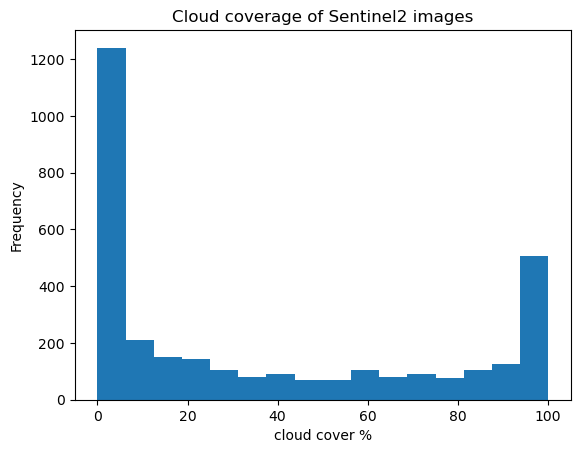

In [21]:
ax: plt.Axes = sentinel_products_metadata.loc[all_products]['cloudcoverpercentage'].plot.hist(bins=16)
ax.set_title('Cloud coverage of Sentinel2 images')
ax.set_xlabel('cloud cover %')

In [22]:
all_metars['timedelta'] = all_metars.apply(lambda row: row['datetime'].to_numpy() - sentinel_products_metadata.loc[row['product_id']]['beginposition'].to_numpy(), axis=1)
all_metars['timedelta [minutes]'] = all_metars['timedelta'].map(lambda x: x.total_seconds() / 60.0)

In [23]:
available_stations_in_products = []
for state, products in products_per_state.items():
    for product in products:
        product_dir = os.path.join(state_dirs.loc[state, 'features'], product)
        product_bands = os.listdir(product_dir)
        stations = set()
        for band in product_bands:
            band_dir = os.path.join(product_dir, band)
            stations = stations.union(set([Path(file).stem for file in os.listdir(band_dir)]))
        for station in stations:
            available_stations_in_products += [{'product_id': product, 'station': station}]
available_stations_in_products = pd.DataFrame(available_stations_in_products)

In [24]:
available_metars = all_metars[(all_metars['product_id'].isin(all_products)) \
                              & (all_metars['sky_conditions [M]'].map(lambda x: len(x) > 0))].copy()
keys = list(available_stations_in_products.columns.values)
i1 = available_metars.set_index(keys).index
i2 = available_stations_in_products.set_index(keys).index
available_metars = available_metars[i1.isin(i2)].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available and satisfy requirements'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

14667 of 20102 METARs are available and satisfy requirements [73.0 %]


In [25]:
def get_newest_label(data:pd.DataFrame):
    return data.loc[data['timedelta [minutes]'].abs().idxmin()]

In [26]:
metars = available_metars.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))
print(f'{metars.shape[0]} of {all_metars.shape[0]} METARs remain for the dataset when only taking the nearest timestamp'
      f' [{float(metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

7801 of 20102 METARs remain for the dataset when only taking the nearest timestamp [38.8 %]


In [27]:
remaining_stations = metars['station'].drop_duplicates().to_numpy()
print(f'{len(remaining_stations)} stations remain')

239 stations remain


In [28]:
clouds = metars['sky_conditions [M]'].apply(lambda skys: [sky.cloud for sky in skys]).to_list()
clouds = pd.Series([item for sublist in clouds for item in sublist])
clouds

0       None
1       None
2       None
3       None
4       None
        ... 
9861    None
9862    None
9863    None
9864    None
9865    None
Length: 9866, dtype: object

In [29]:
Counter(clouds)

Counter({None: 9860, 'CB': 5, 'TCU': 1})

Text(0.5, 0, 'time offset in minutes')

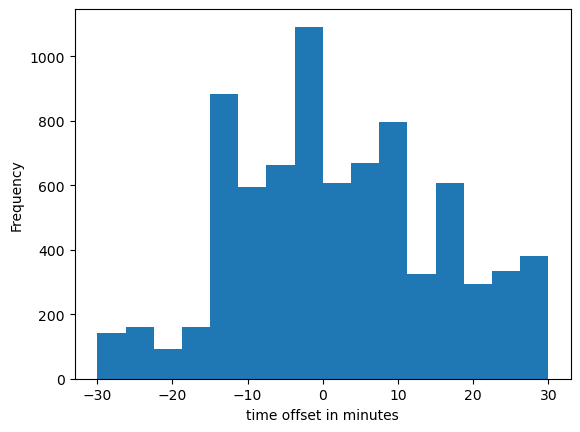

In [30]:
ax: plt.Axes = metars['timedelta [minutes]'].plot.hist(bins=16)
ax.set_xlabel('time offset in minutes')

In [31]:
station_radius_of_influence = 8000.0 # meters

In [32]:
polygons: List[Polygon] = []
for geometry in usa_states.loc[target_states].geometry:
    if isinstance(geometry, MultiPolygon):
        polygons += list(geometry.geoms)
    elif isinstance(geometry, Polygon):
        polygons += [geometry]

<class 'shapely.geometry.multipolygon.MultiPolygon'>


<Axes: >

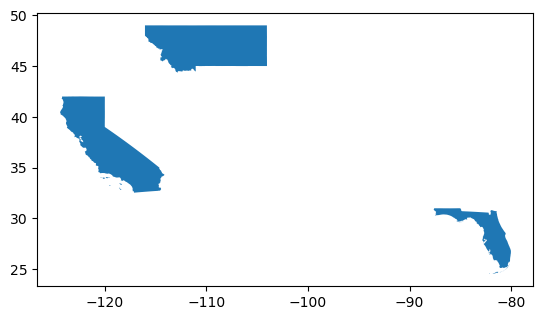

In [33]:
area_of_interest: MultiPolygon = unary_union(polygons)
print(type(area_of_interest))
gpd.GeoSeries(area_of_interest).plot()

In [34]:
def plot_state(ax:plt.Axes, state:str, color:str):
    gpd.GeoSeries(usa_states.loc[state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [35]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [36]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [37]:
remaining_stations_metadata = station_metadata.loc[remaining_stations]

In [38]:
remaining_stations_metadata['geometry'] = remaining_stations_metadata['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
)

In [39]:
intersections: gpd.GeoDataFrame = remaining_stations_metadata[['geometry']].sjoin(remaining_stations_metadata[['geometry']], predicate="intersects")

In [40]:
intersections = intersections[intersections['index_right'] != intersections.index]

In [41]:
intersections = intersections.sample(frac=1, random_state=1)

In [42]:
intersections.head()

,geometry,index_right
id,,
HHR,"POLYGON ((-118.25717 33.85782, -118.25717 33.98787, -118.41317 33.98787, -118.41317 33.85782, -118.25717 33.85782))",CQT
CQT,"POLYGON ((-118.21305 33.95848, -118.21305 34.08860, -118.36932 34.08860, -118.36932 33.95848, -118.21305 33.95848))",LAX
LPC,"POLYGON ((-120.38974 34.60139, -120.38974 34.72986, -120.54522 34.72986, -120.54522 34.60139, -120.38974 34.60139))",VBG
DVO,"POLYGON ((-122.47494 38.07954, -122.47494 38.20770, -122.63721 38.20770, -122.63721 38.07954, -122.47494 38.07954))",O69
NXF,"POLYGON ((-117.37868 33.22032, -117.37868 33.35097, -117.53423 33.35097, -117.53423 33.22032, -117.37868 33.22032))",OKB


In [43]:
intersections_groups = intersections[['index_right']].groupby('index_right').groups
print(intersections_groups)

{'9L2': ['EDW'], 'AJO': ['CNO'], 'BAB': ['MYV'], 'BCT': ['PMP'], 'BOW': ['GIF'], 'BUR': ['WHP', 'VNY'], 'CCB': ['ONT', 'POC'], 'CEW': ['EGI'], 'CNO': ['ONT', 'POC', 'AJO'], 'COF': ['MLB'], 'CQT': ['HHR', 'SMO', 'LAX'], 'CRG': ['NIP', 'NRB'], 'CRQ': ['OKB'], 'DAB': ['OMN'], 'DTS': ['VPS'], 'DVO': ['O69'], 'EDW': ['9L2'], 'EGI': ['CEW'], 'EYW': ['NQX'], 'FLL': ['HWO'], 'FMY': ['RSW'], 'GFA': ['GTF'], 'GIF': ['BOW'], 'GTF': ['GFA'], 'HAF': ['SFO'], 'HEG': ['NIP', 'VQQ'], 'HHR': ['LAX', 'TOA', 'SMO', 'CQT'], 'HRT': ['VPS'], 'HWD': ['OAK'], 'HWO': ['OPF', 'FLL'], 'IPL': ['NJK'], 'ISM': ['MCO'], 'L18': ['NFG'], 'LAX': ['CQT', 'SMO', 'HHR'], 'LNA': ['PBI'], 'LPC': ['VBG'], 'MCC': ['MHR'], 'MCE': ['MER'], 'MCO': ['ISM', 'ORL'], 'MER': ['MCE'], 'MHR': ['MCC'], 'MIA': ['OPF'], 'MLB': ['COF'], 'MYF': ['SAN', 'NZY', 'NKX'], 'MYV': ['BAB'], 'NFG': ['L18', 'OKB', 'NXF'], 'NIP': ['HEG', 'CRG'], 'NJK': ['IPL'], 'NKX': ['SAN', 'MYF'], 'NPA': ['PNS'], 'NQX': ['EYW'], 'NRB': ['CRG'], 'NRS': ['NZY'], 'NUQ

In [44]:
import networkx
import networkx.convert
graph = networkx.convert.from_dict_of_lists(intersections_groups)

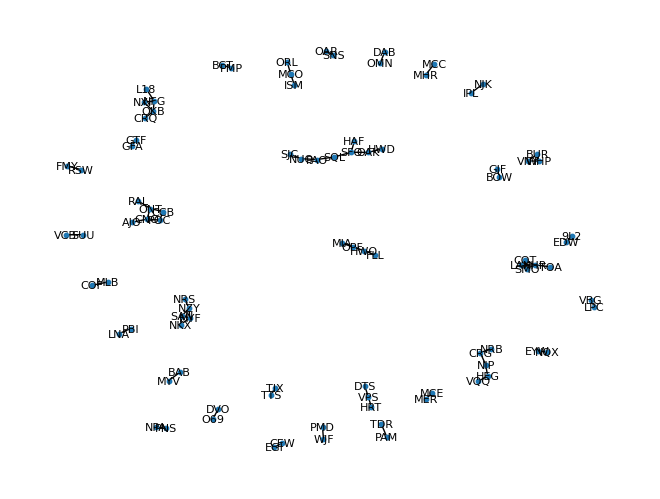

In [45]:
networkx.draw(graph, with_labels=True, font_size=8, node_size=10)

In [46]:
clusters = list(networkx.connected_components(graph))
print(clusters)
num_clusters = len(clusters)

[{'EDW', '9L2'}, {'RAL', 'POC', 'AJO', 'CNO', 'CCB', 'ONT'}, {'MYV', 'BAB'}, {'PMP', 'BCT'}, {'BOW', 'GIF'}, {'VNY', 'BUR', 'WHP'}, {'CEW', 'EGI'}, {'COF', 'MLB'}, {'CQT', 'SMO', 'HHR', 'TOA', 'LAX'}, {'HEG', 'VQQ', 'NRB', 'NIP', 'CRG'}, {'CRQ', 'NFG', 'OKB', 'NXF', 'L18'}, {'DAB', 'OMN'}, {'DTS', 'VPS', 'HRT'}, {'DVO', 'O69'}, {'NQX', 'EYW'}, {'OPF', 'FLL', 'MIA', 'HWO'}, {'RSW', 'FMY'}, {'GTF', 'GFA'}, {'NUQ', 'PAO', 'SFO', 'HAF', 'HWD', 'OAK', 'SJC', 'SQL'}, {'NJK', 'IPL'}, {'ORL', 'ISM', 'MCO'}, {'PBI', 'LNA'}, {'VBG', 'LPC'}, {'MHR', 'MCC'}, {'MER', 'MCE'}, {'SAN', 'NKX', 'MYF', 'NRS', 'NZY'}, {'PNS', 'NPA'}, {'SNS', 'OAR'}, {'TDR', 'PAM'}, {'WJF', 'PMD'}, {'VCB', 'SUU'}, {'TIX', 'TTS'}]


In [47]:
def get_mapping_from_clusters(clusters:List[Set[str]]):
    mapping = {}
    current_cluster = 0
    for cluster in clusters:
        for node in cluster:
            mapping[node] = current_cluster
        current_cluster += 1
    return mapping

node_to_cluster_mapping = get_mapping_from_clusters(clusters)
print(node_to_cluster_mapping)

{'EDW': 0, '9L2': 0, 'RAL': 1, 'POC': 1, 'AJO': 1, 'CNO': 1, 'CCB': 1, 'ONT': 1, 'MYV': 2, 'BAB': 2, 'PMP': 3, 'BCT': 3, 'BOW': 4, 'GIF': 4, 'VNY': 5, 'BUR': 5, 'WHP': 5, 'CEW': 6, 'EGI': 6, 'COF': 7, 'MLB': 7, 'CQT': 8, 'SMO': 8, 'HHR': 8, 'TOA': 8, 'LAX': 8, 'HEG': 9, 'VQQ': 9, 'NRB': 9, 'NIP': 9, 'CRG': 9, 'CRQ': 10, 'NFG': 10, 'OKB': 10, 'NXF': 10, 'L18': 10, 'DAB': 11, 'OMN': 11, 'DTS': 12, 'VPS': 12, 'HRT': 12, 'DVO': 13, 'O69': 13, 'NQX': 14, 'EYW': 14, 'OPF': 15, 'FLL': 15, 'MIA': 15, 'HWO': 15, 'RSW': 16, 'FMY': 16, 'GTF': 17, 'GFA': 17, 'NUQ': 18, 'PAO': 18, 'SFO': 18, 'HAF': 18, 'HWD': 18, 'OAK': 18, 'SJC': 18, 'SQL': 18, 'NJK': 19, 'IPL': 19, 'ORL': 20, 'ISM': 20, 'MCO': 20, 'PBI': 21, 'LNA': 21, 'VBG': 22, 'LPC': 22, 'MHR': 23, 'MCC': 23, 'MER': 24, 'MCE': 24, 'SAN': 25, 'NKX': 25, 'MYF': 25, 'NRS': 25, 'NZY': 25, 'PNS': 26, 'NPA': 26, 'SNS': 27, 'OAR': 27, 'TDR': 28, 'PAM': 28, 'WJF': 29, 'PMD': 29, 'VCB': 30, 'SUU': 30, 'TIX': 31, 'TTS': 31}


In [48]:
clusted_stations = intersections.index.to_list()
print(clusted_stations)
remaining_stations_metadata['cluster'] = remaining_stations_metadata['name'].apply(
    lambda x: node_to_cluster_mapping[x] if x in clusted_stations else -1
)

['HHR', 'CQT', 'LPC', 'DVO', 'NXF', '9L2', 'SJC', 'NJK', 'HWD', 'MHR', 'NFG', 'MCC', 'SMO', 'SQL', 'NIP', 'PNS', 'LAX', 'SAN', 'ONT', 'IPL', 'SFO', 'VBG', 'HHR', 'VNY', 'O69', 'CCB', 'MCE', 'TOA', 'NUQ', 'MCO', 'HHR', 'ONT', 'CNO', 'OKB', 'L18', 'EGI', 'TTS', 'CQT', 'DAB', 'VCB', 'OKB', 'PBI', 'HEG', 'SNS', 'POC', 'SFO', 'NZY', 'PMP', 'GFA', 'NUQ', 'RSW', 'SQL', 'MYF', 'HEG', 'BCT', 'EYW', 'NZY', 'NZY', 'HRT', 'SMO', 'CQT', 'PMD', 'SMO', 'OPF', 'OMN', 'ONT', 'WHP', 'HWO', 'OKB', 'MCO', 'MYV', 'NKX', 'SAN', 'FMY', 'RAL', 'AJO', 'NFG', 'BOW', 'LAX', 'OAK', 'VNY', 'NKX', 'LAX', 'TDR', 'MER', 'VQQ', 'BAB', 'HAF', 'OPF', 'MYF', 'TIX', 'CNO', 'BUR', 'POC', 'GTF', 'EDW', 'CRG', 'VPS', 'NFG', 'SFO', 'COF', 'MLB', 'PAO', 'MIA', 'PAO', 'CRQ', 'SUU', 'DTS', 'NQX', 'VPS', 'NIP', 'WJF', 'OAR', 'ISM', 'NPA', 'NRB', 'NXF', 'CNO', 'GIF', 'WHP', 'BUR', 'ORL', 'CEW', 'CRG', 'FLL', 'LNA', 'HWO', 'OAK', 'PAM', 'NRS', 'CCB', 'MYF', 'SAN', 'HHR']


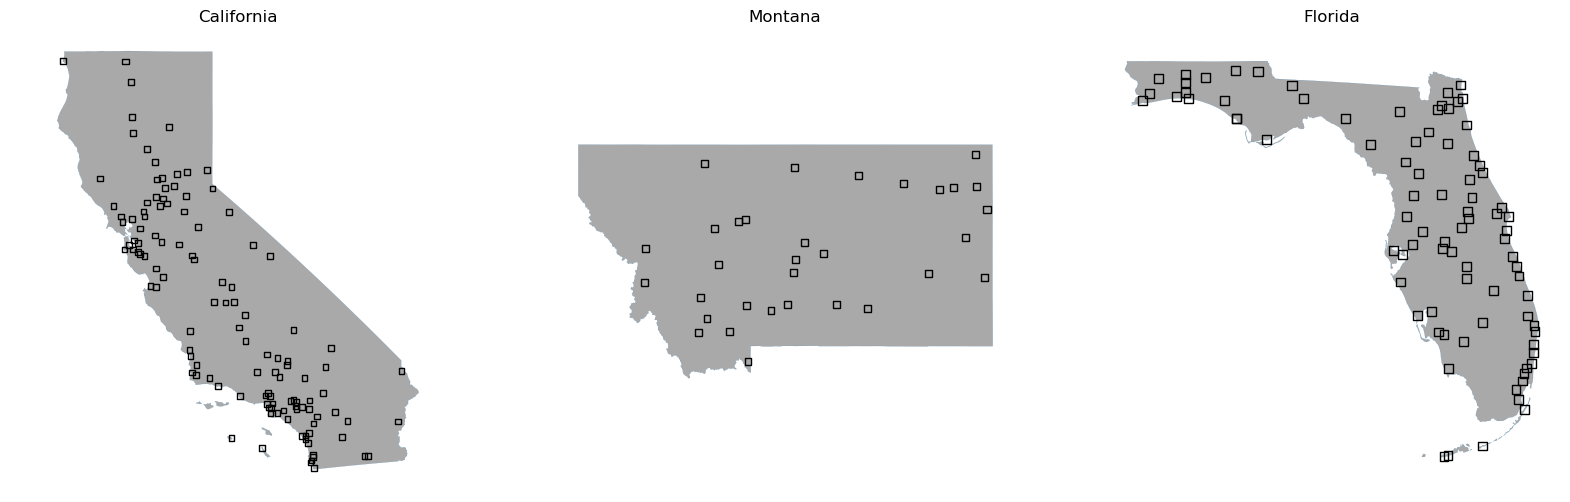

In [49]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[remaining_stations_metadata['state'] == state].plot(
        ax=ax, facecolor='none', edgecolor='black', legend=True
    )

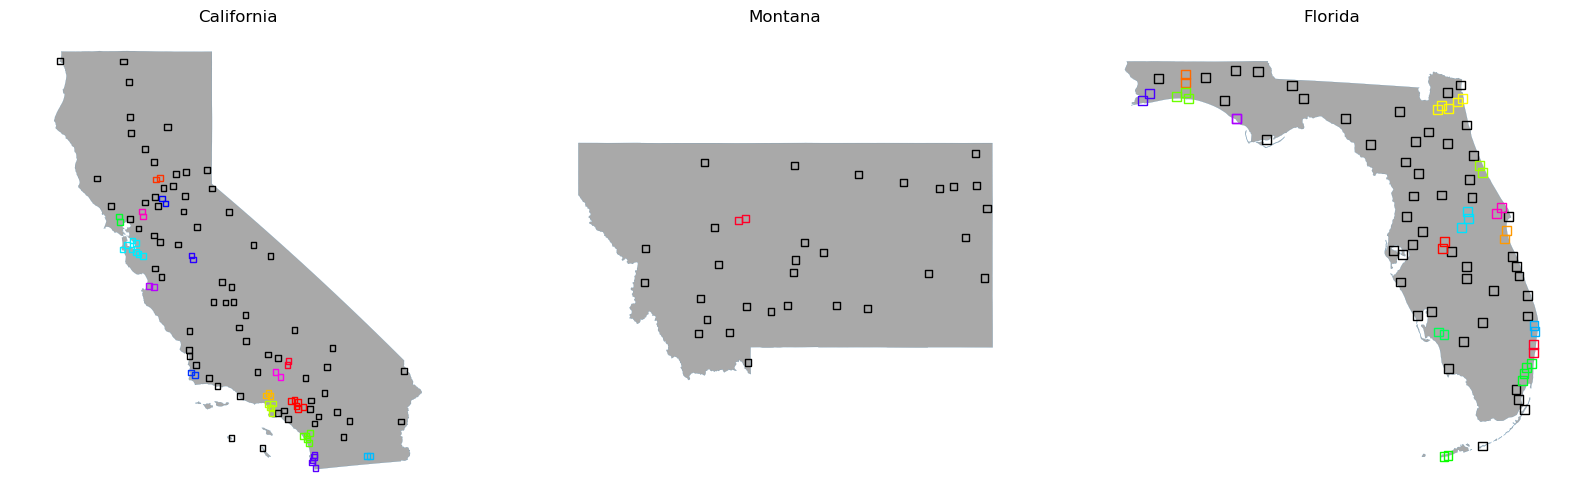

In [50]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] == -1)].plot(
        ax=ax, facecolor='none', edgecolor='black', legend=False
    )
    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].plot(
        column='cluster', ax=ax, facecolor='none', cmap='gist_rainbow', legend=False
    )

In [51]:
cloud_covers = pd.DataFrame(metars['sky_conditions [M]'])
cloud_covers['cloud cover'] = cloud_covers['sky_conditions [M]'].apply(lambda sky_conditions: [cond.cover for cond in sky_conditions])
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                        
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MLB                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                           ...   
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ      [DataSkyConditions(cover='OVC', height=182.8799941478, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO      [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     DLN                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     RVF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   

                                             cloud cover  
product_id                           station              
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]  
                                     MLB           [CLR]  
                                     TIX           [CLR]  
                                     TTS           [CLR]  
                                     XMR           [CLR]  
...                                                  ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ           [OVC]  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]  
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM           [CLR]  
                                     DLN           [CLR]  
                                     RVF           [CLR]  

[7801 rows x 2 columns]

In [52]:
cloud_covers_flat = [item for sublist in cloud_covers['cloud cover'] for item in sublist]
print(cloud_covers_flat)

['CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'BKN', 'BKN', 'SCT', 'BKN', 'FEW', 'FEW', 'SCT', 'SCT', 'BKN', 'CLR', 'FEW', 'SCT', 'SCT', 'BKN', 'BKN', 'BKN', 'CLR', 'SCT', 'BKN', 'OVC', 'VV', 'SCT', 'BKN', 'OVC', 'FEW', 'FEW', 'BKN', 'FEW', 'FEW', 'BKN', 'BKN', 'SCT', 'BKN', 'FEW', 'BKN', 'BKN', 'OVC', 'BKN', 'CLR', 'SCT', 'SCT', 'CLR', 'CLR', 'BKN', 'FEW', 'FEW', 'SCT', 'BKN', 'BKN', 'CLR', 'OVC', 'OVC', 'FEW', 'CLR', 'FEW', 'CLR', 'SCT', 'BKN', 'SCT', 'BKN', 'OVC', 'CLR', 'BKN', 'BKN', 'BKN', 'FEW', 'SCT', 'CLR', 'CLR', 'SCT', 'BKN', 'BKN', 'BKN', 'BKN', 'FEW', 'FEW', 'BKN', 'BKN', 'OVC', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'SCT', 'OVC', 'BKN', 'OVC', 'SCT', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'OVC', 'BKN', 'OVC', 'CLR', 'OVC', 'SCT', 'OVC', 'SCT', 'OVC', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR', 'FEW', 'FEW', 'FEW', 'FEW', 'FEW', 'SCT', 'FEW', 'FEW', 'SCT', 'SCT', 'CLR',

<Axes: >

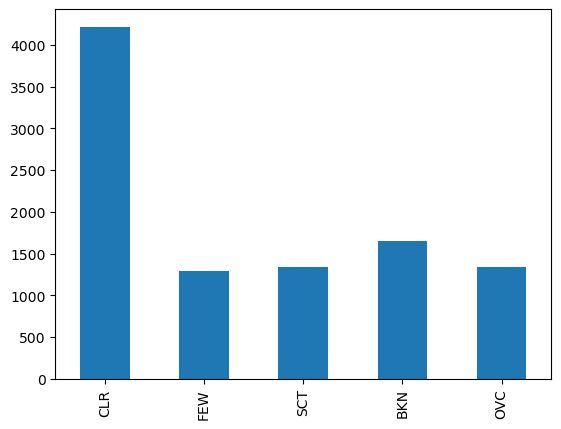

In [53]:
pd.Series(dict(Counter(cloud_covers_flat))).loc[cloud_covers_order].plot(kind='bar')

In [54]:
cloud_cover_strength = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [55]:
metars['max cloud cover'] = metars['sky_conditions [M]'].apply(get_max_cloud_cover)
metars = metars[metars['max cloud cover'].isin(cloud_covers_order)]

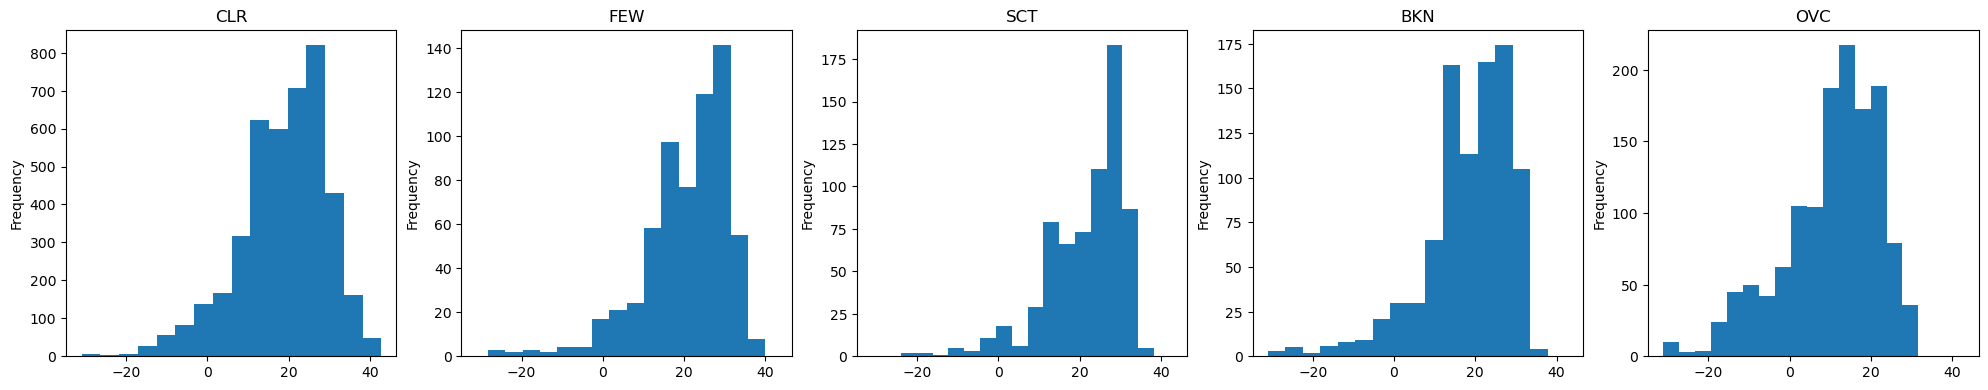

In [56]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(cloud_covers_order), sharex=True)
fig.tight_layout(pad=1.6)
for i, cc in enumerate(cloud_covers_order):
    ax: plt.Axes = axs[i]
    ax.set_title(cc)
    metars[metars['max cloud cover'] == cc]['temperature [C]'].plot.hist(ax=ax, bins=16)

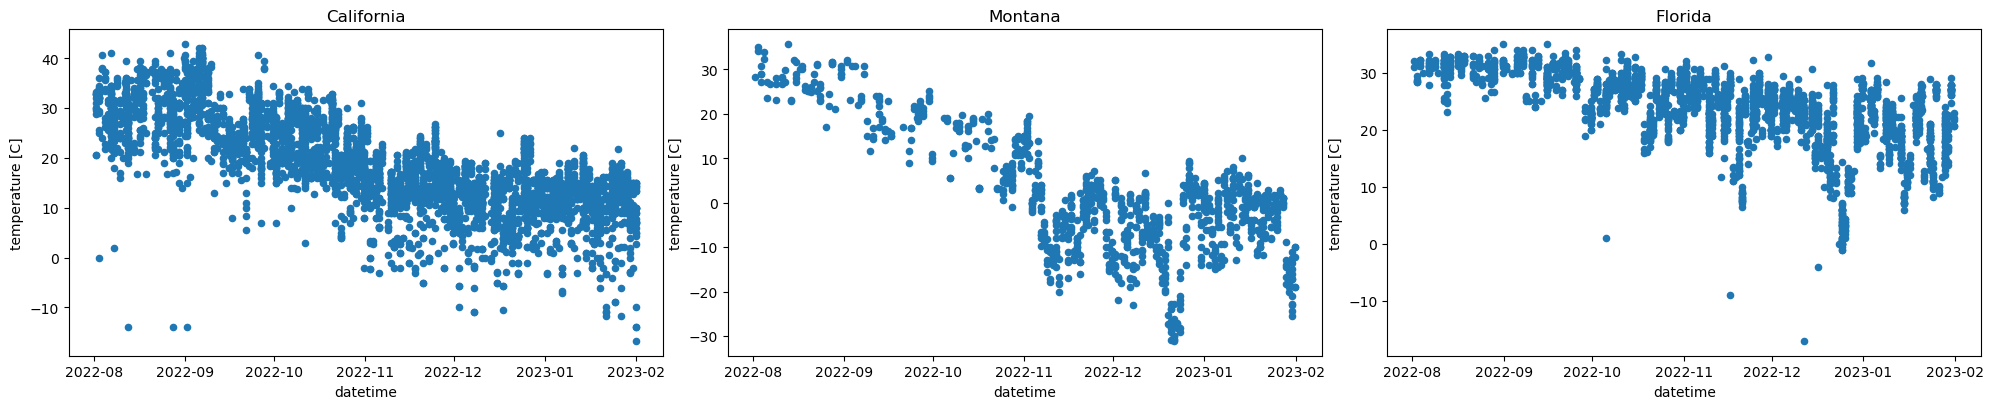

In [57]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states), sharex=True)
fig.tight_layout(pad=1.6)
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_title(state)
    local_stations = station_metadata[station_metadata['state'] == state]
    metars[metars['station'].isin(local_stations.index)].plot.scatter(ax=ax, x='datetime', y='temperature [C]')

In [58]:
metars.columns

Index(['station', 'datetime', 'temperature [C]', 'current_weather',
       'recent_weather', 'sky_conditions [M]', 'metar_code', 'product_id',
       'timedelta', 'timedelta [minutes]', 'max cloud cover'],
      dtype='object')

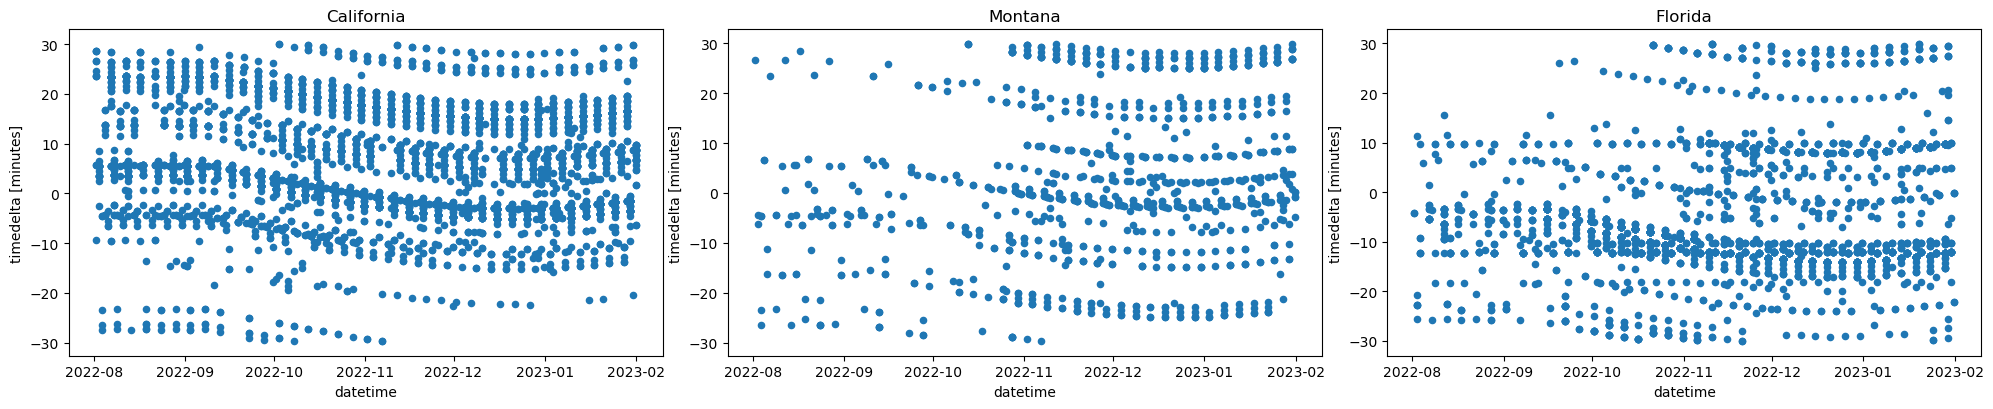

In [59]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states), sharex=True)
fig.tight_layout(pad=1.6)
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_title(state)
    local_stations = station_metadata[station_metadata['state'] == state]
    metars[metars['station'].isin(local_stations.index)].plot.scatter(ax=ax, x='datetime', y='timedelta [minutes]')

In [60]:
metars['cloud cover'] = metars['sky_conditions [M]'].apply(lambda x: [sky.cover for sky in x])
metars['cloud cover']

product_id                            station
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9  COF        [CLR]
                                      MLB        [CLR]
                                      TIX        [CLR]
                                      TTS        [CLR]
                                      XMR        [CLR]
                                                 ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d  LCQ        [OVC]
ffef155f-3c61-4e07-a2c4-39a61331917d  DLO        [OVC]
fff87278-9cf2-452f-b630-8d8f5bfa60f1  BTM        [CLR]
                                      DLN        [CLR]
                                      RVF        [CLR]
Name: cloud cover, Length: 7783, dtype: object

In [61]:
tmp = metars['cloud cover'].apply(lambda x: (len(x) == 1) or any([cc == 'OVC' for cc in x]))
ambiguous_cc_metars = metars[~tmp]
true_cc_metars = metars[tmp]
print(f'{ambiguous_cc_metars.shape[0]} of {metars.shape[0]} have ambiguous cloud coverage'
      f'[{ambiguous_cc_metars.shape[0] / metars.shape[0] * 100.0:.1f} %]')
print(true_cc_metars['cloud cover'].head())
print(ambiguous_cc_metars['cloud cover'].head())

900 of 7783 have ambiguous cloud coverage[11.6 %]
product_id                            station
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9  COF        [CLR]
                                      MLB        [CLR]
                                      TIX        [CLR]
                                      TTS        [CLR]
                                      XMR        [CLR]
Name: cloud cover, dtype: object
product_id                            station
001be058-4542-4cbd-b469-6677cc086ff3  LCQ                  [BKN, BKN]
002276a1-d3f5-494d-93c8-92e199d63501  APC                  [SCT, BKN]
                                      DWA             [SCT, SCT, BKN]
                                      STS                  [FEW, SCT]
                                      SUU        [SCT, BKN, BKN, BKN]
Name: cloud cover, dtype: object


<Axes: >

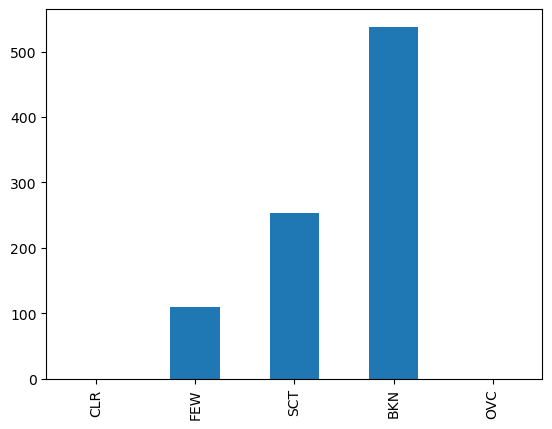

In [62]:
ambiguous_cc_metars_ctr = dict(Counter(ambiguous_cc_metars['max cloud cover']))
for cc in cloud_covers_order:
    if cc not in ambiguous_cc_metars_ctr:
        ambiguous_cc_metars_ctr[cc] = 0
pd.Series(ambiguous_cc_metars_ctr).loc[cloud_covers_order].plot(kind='bar')

<Axes: >

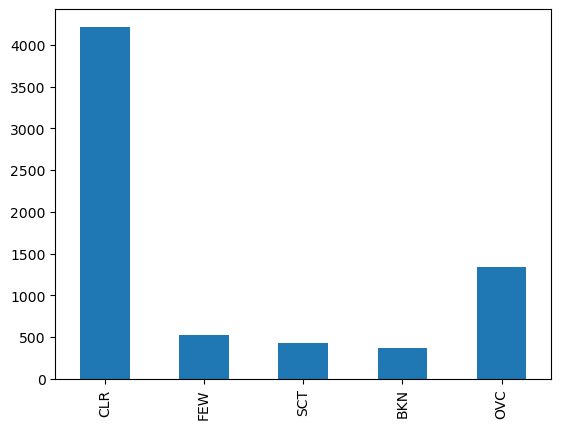

In [63]:
true_cc_metars_ctr = dict(Counter(true_cc_metars['max cloud cover']))
for cc in cloud_covers_order:
    if cc not in true_cc_metars_ctr:
        true_cc_metars_ctr[cc] = 0
pd.Series(true_cc_metars_ctr).loc[cloud_covers_order].plot(kind='bar')

                      datetime  CLR  FEW  SCT  BKN  OVC
0    2022-08-01 15:55:00+00:00  2.0  NaN  NaN  NaN  NaN
1    2022-08-01 18:20:00+00:00  1.0  NaN  NaN  NaN  NaN
2    2022-08-01 18:35:00+00:00  2.0  NaN  NaN  NaN  NaN
3    2022-08-01 18:53:00+00:00  NaN  1.0  2.0  NaN  NaN
4    2022-08-01 18:54:00+00:00  1.0  NaN  NaN  NaN  NaN
...                        ...  ...  ...  ...  ...  ...
2406 2023-01-31 18:52:00+00:00  1.0  NaN  NaN  NaN  NaN
2407 2023-01-31 18:53:00+00:00  7.0  NaN  NaN  NaN  NaN
2408 2023-01-31 18:54:00+00:00  1.0  NaN  NaN  NaN  1.0
2409 2023-01-31 18:55:00+00:00  7.0  NaN  NaN  NaN  NaN
2410 2023-01-31 18:56:00+00:00  2.0  NaN  3.0  NaN  NaN

[2411 rows x 6 columns]


c:\Users\erikw\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


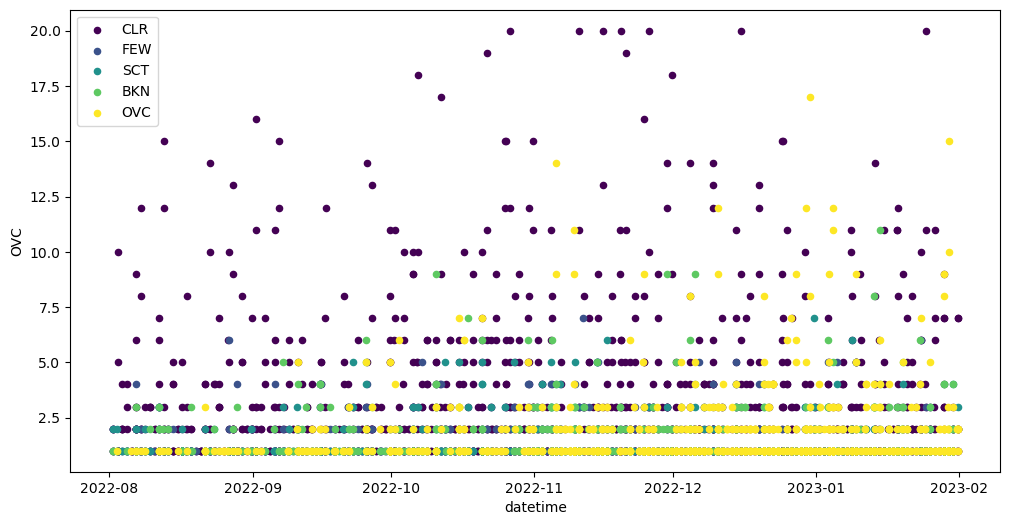

In [64]:
fig,ax = plt.subplots(figsize=(12,6))

data = []
for cc in cloud_covers_order:
    metars_selection = metars[metars['max cloud cover']==cc]
    data += [metars_selection[['datetime', 'max cloud cover']].groupby('datetime').value_counts().reset_index('max cloud cover', drop=True)]
data = pd.DataFrame(data).T
data.columns = cloud_covers_order
data.reset_index(inplace=True)
print(data)

colors = cm.viridis(np.linspace(0, 1, len(cloud_covers_order)))
for cc, color in zip(cloud_covers_order, colors):
    data.plot.scatter(ax=ax, x='datetime', y=cc, c=color)

ax.legend(cloud_covers_order, loc='best')

In [65]:
cloud_covers['cloud cover max'] = cloud_covers['sky_conditions [M]'].map(get_max_cloud_cover)
cloud_covers['cloud cover max']

product_id                            station
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9  COF        CLR
                                      MLB        CLR
                                      TIX        CLR
                                      TTS        CLR
                                      XMR        CLR
                                                ... 
ffd75b3f-eebb-4200-9577-d705bcdcf84d  LCQ        OVC
ffef155f-3c61-4e07-a2c4-39a61331917d  DLO        OVC
fff87278-9cf2-452f-b630-8d8f5bfa60f1  BTM        CLR
                                      DLN        CLR
                                      RVF        CLR
Name: cloud cover max, Length: 7801, dtype: object

In [66]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))

CLR    4217
BKN     906
FEW     636
SCT     685
OVC    1339
VV       18
dtype: int64

In [67]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order]

CLR    4217
FEW     636
SCT     685
BKN     906
OVC    1339
dtype: int64

In [68]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].sum()

7783

<Axes: title={'center': 'Maximum cloud coverage by weather stations'}>

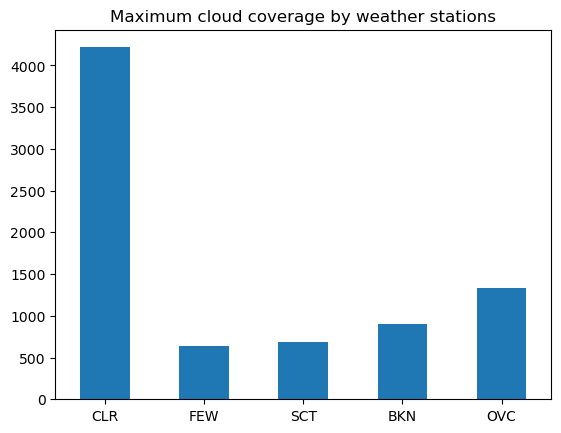

In [69]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].plot(kind='bar', title='Maximum cloud coverage by weather stations', rot=0)

In [70]:
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                        
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MLB                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                           ...   
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ      [DataSkyConditions(cover='OVC', height=182.8799941478, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO      [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     DLN                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     RVF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   

                                             cloud cover cloud cover max  
product_id                           station                              
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]             CLR  
                                     MLB           [CLR]             CLR  
                                     TIX           [CLR]             CLR  
                                     TTS           [CLR]             CLR  
                                     XMR           [CLR]             CLR  
...                                                  ...             ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ           [OVC]             OVC  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]             OVC  
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM           [CLR]             CLR  
                                     DLN           [CLR]             CLR  
                                     RVF           [CLR]             CLR  

[7801 rows x 3 columns]

In [71]:
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                        
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MLB                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                           ...   
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ      [DataSkyConditions(cover='OVC', height=182.8799941478, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO      [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     DLN                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     RVF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   

                                             cloud cover cloud cover max  
product_id                           station                              
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]             CLR  
                                     MLB           [CLR]             CLR  
                                     TIX           [CLR]             CLR  
                                     TTS           [CLR]             CLR  
                                     XMR           [CLR]             CLR  
...                                                  ...             ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ           [OVC]             OVC  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]             OVC  
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM           [CLR]             CLR  
                                     DLN           [CLR]             CLR  
                                     RVF           [CLR]             CLR  

[7801 rows x 3 columns]

In [72]:
cloud_covers_max_per_station = {}
for station, data in cloud_covers.groupby('station'):
    cloud_covers_max_per_station[station] = pd.Series(dict(Counter(data['cloud cover max'])))
cloud_covers_max_per_station = pd.DataFrame(cloud_covers_max_per_station)
cloud_covers_max_per_station

,00U,1GM,1KM,1LM,28J,2IS,2J9,42J,54A,54J,...,VQQ,VRB,WHP,WJF,WYS,X07,X26,X60,XMR,ZPH
BKN,2.0,1.0,4.0,2.0,4.0,2.0,2.0,3.0,1.0,1.0,...,9.0,7.0,1.0,1.0,1.0,4.0,13.0,3.0,5.0,5.0
CLR,11.0,31.0,25.0,7.0,15.0,9.0,17.0,15.0,12.0,14.0,...,17.0,5.0,21.0,33.0,5.0,13.0,22.0,15.0,34.0,10.0
FEW,1.0,3.0,3.0,1.0,4.0,NaN,1.0,2.0,3.0,NaN,...,NaN,8.0,NaN,1.0,NaN,1.0,NaN,NaN,11.0,NaN
OVC,1.0,4.0,13.0,7.0,5.0,5.0,7.0,5.0,3.0,4.0,...,4.0,3.0,3.0,2.0,NaN,6.0,11.0,5.0,3.0,9.0
SCT,1.0,2.0,2.0,NaN,3.0,7.0,2.0,4.0,3.0,7.0,...,1.0,9.0,1.0,NaN,NaN,2.0,16.0,5.0,4.0,3.0
VV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


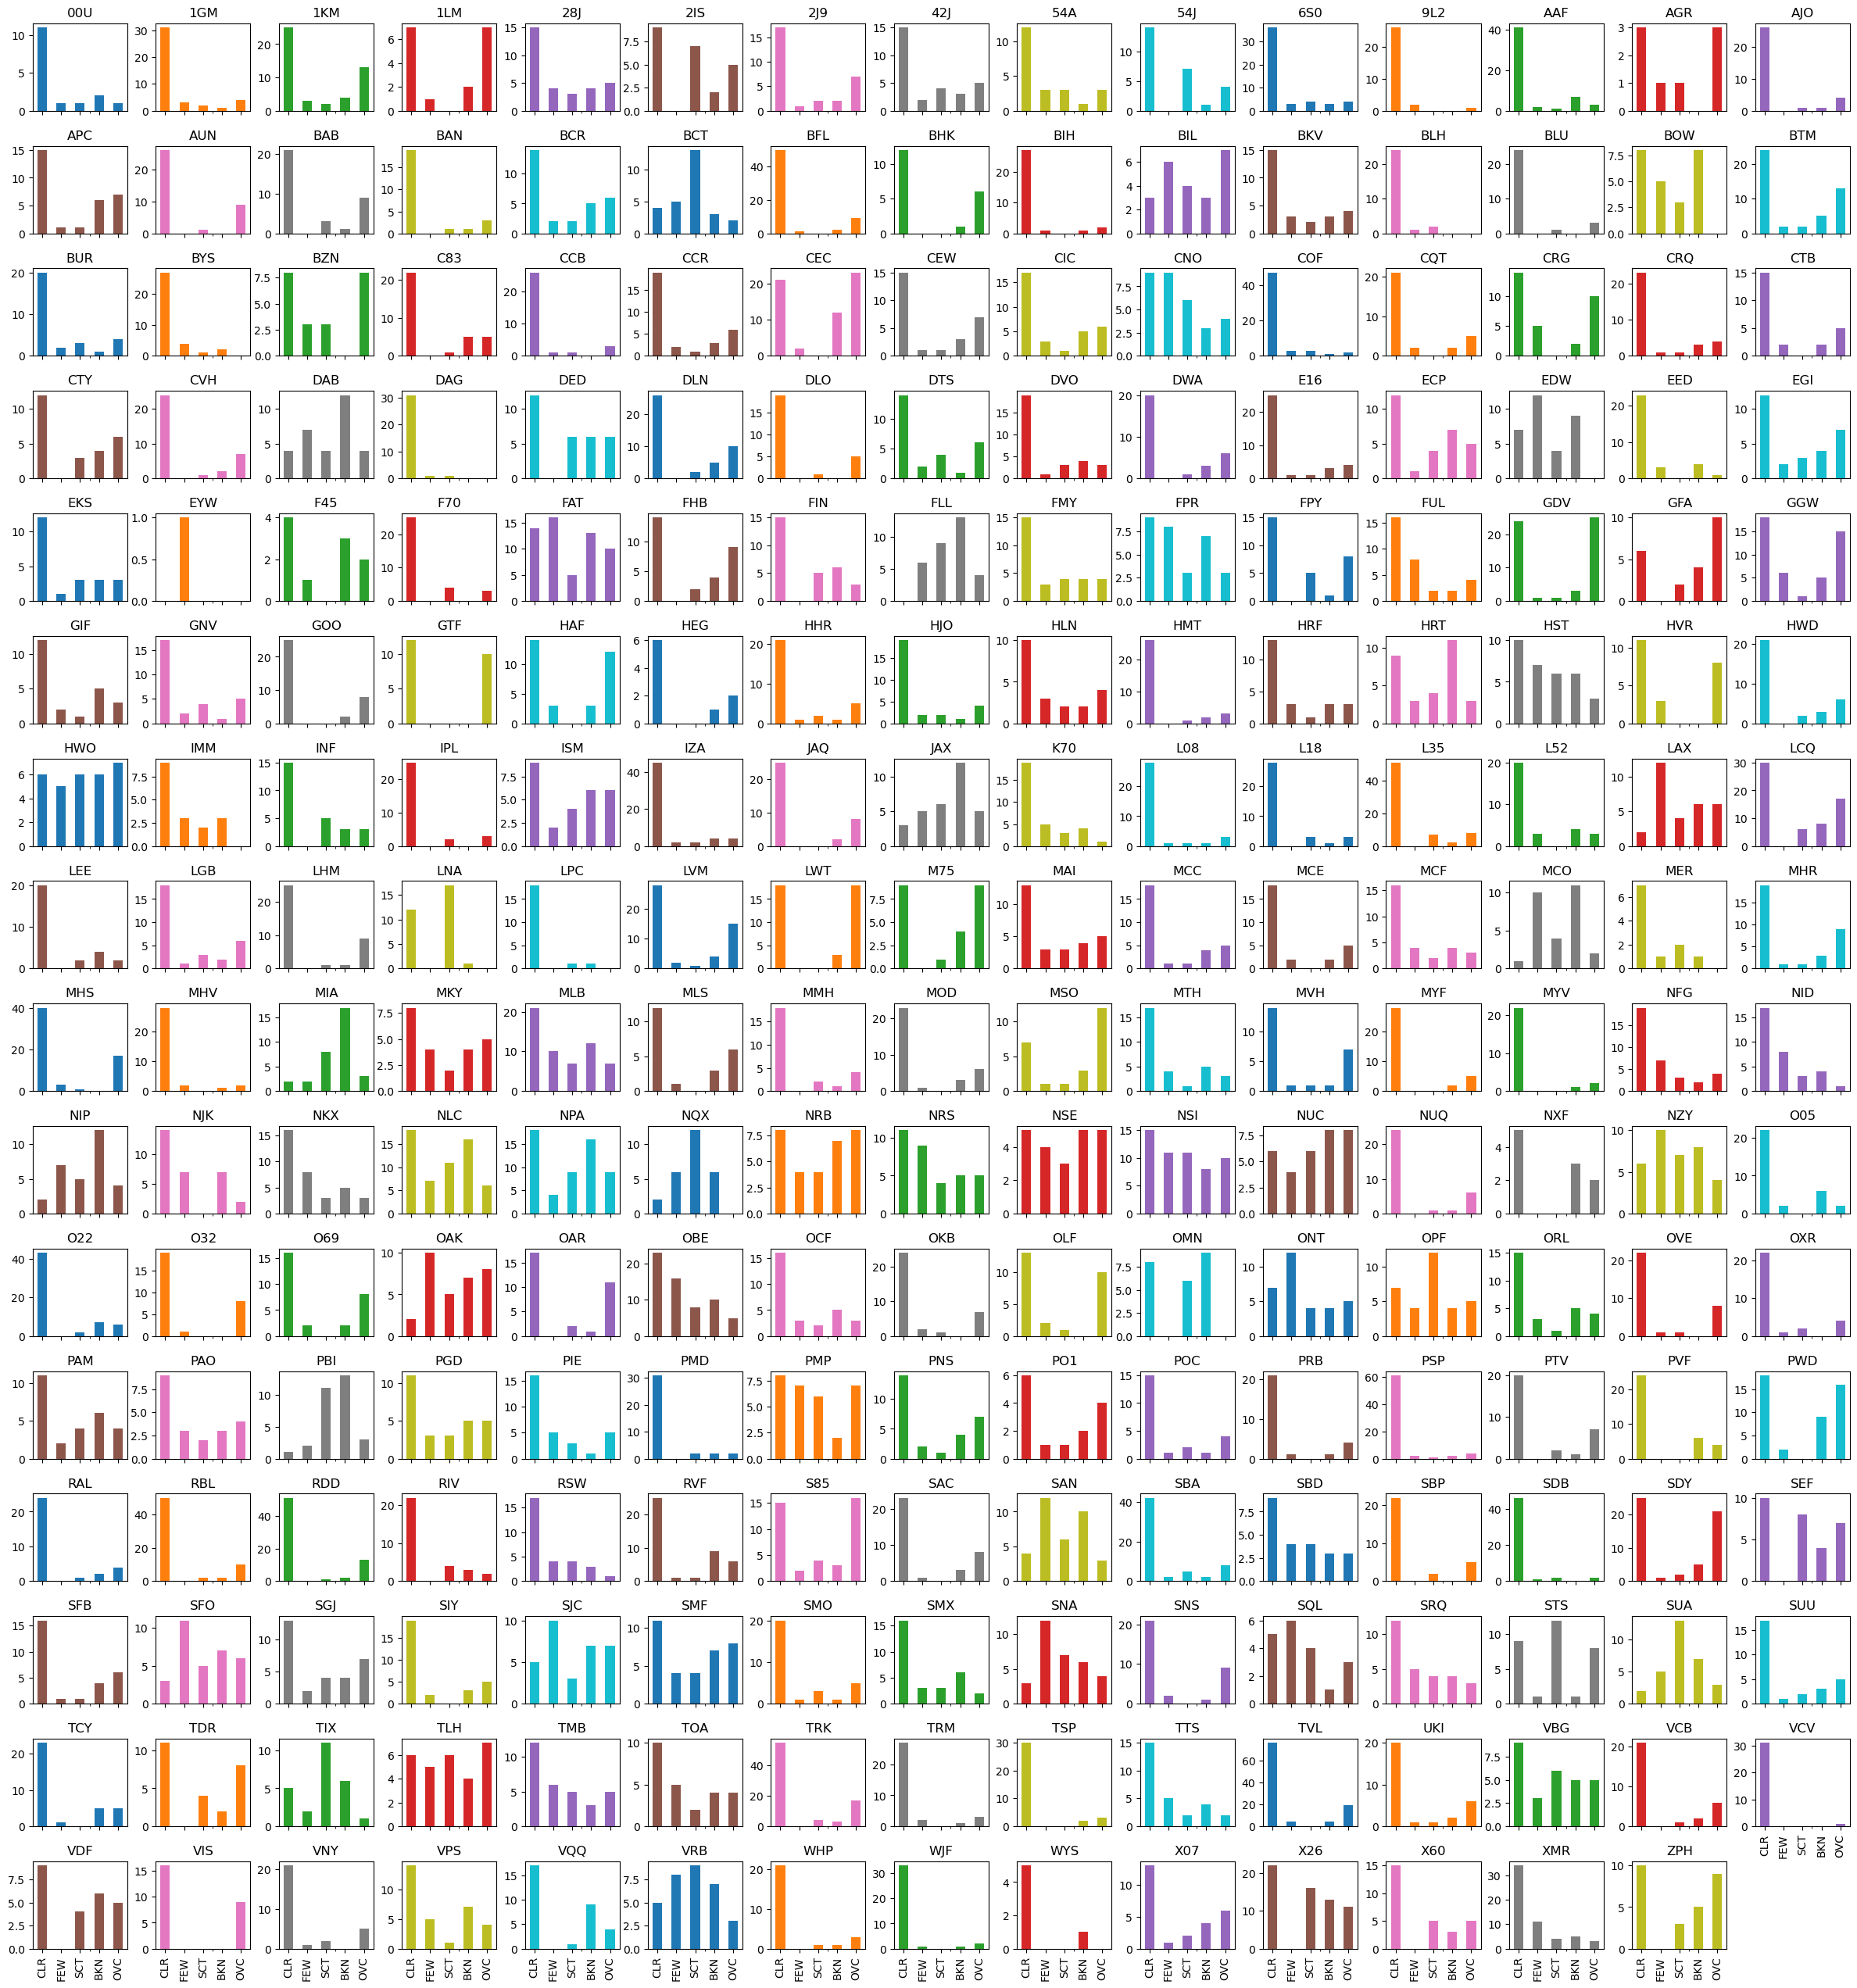

In [73]:
from numpy import ceil

plot_share_x = True
plot_layout_scale = 2.0
plot_layout_columns = 15
plot_layout_rows = int(ceil(cloud_covers_max_per_station.shape[1] / plot_layout_columns))
cloud_covers_max_per_station.loc[cloud_covers_order].plot(kind='bar', sharex=plot_share_x, subplots=True, legend=False,
    layout=(plot_layout_rows, plot_layout_columns),
    figsize=(plot_layout_columns * plot_layout_scale, plot_layout_rows * plot_layout_scale))
if not plot_share_x:
    plt.subplots_adjust(wspace=0.3, hspace=1.0)
else:
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [74]:
metar_station_counts = metars.reset_index(drop=True).groupby(['station'])['product_id'].count().sort_values()

<Axes: xlabel='station'>

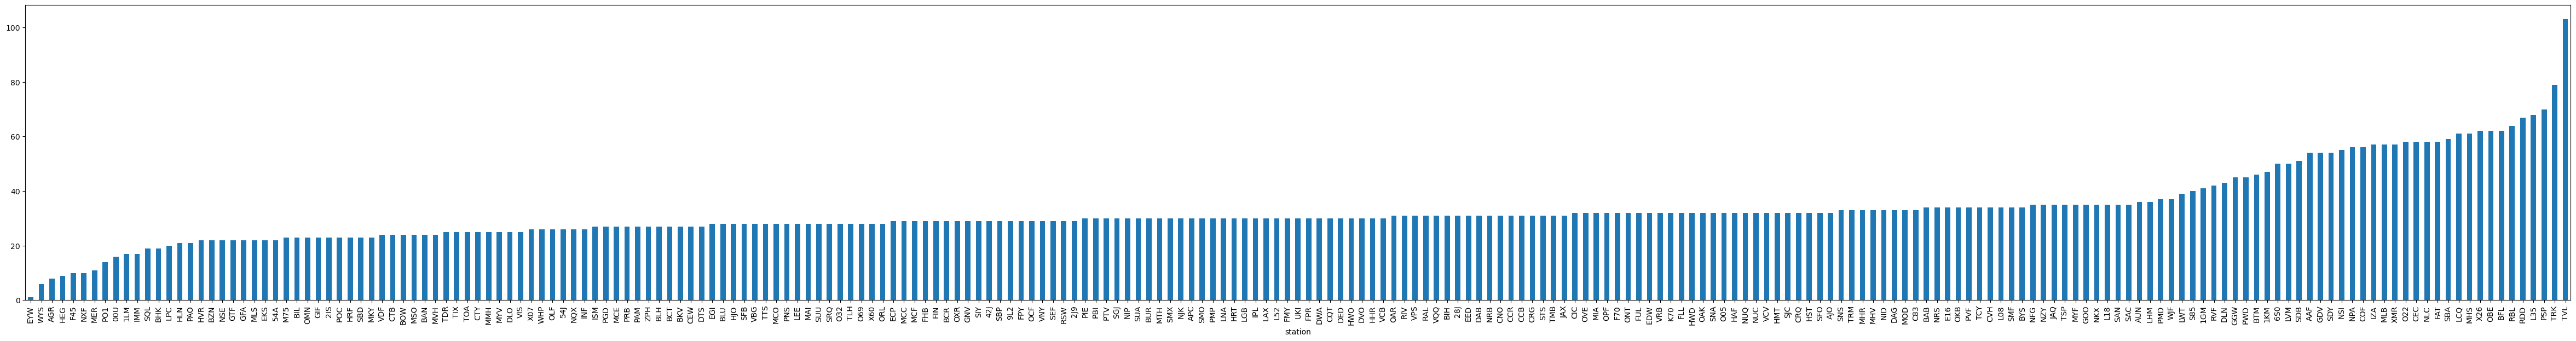

In [75]:
metar_station_counts.plot(kind='bar', figsize=(60,7))

<Axes: ylabel='Frequency'>

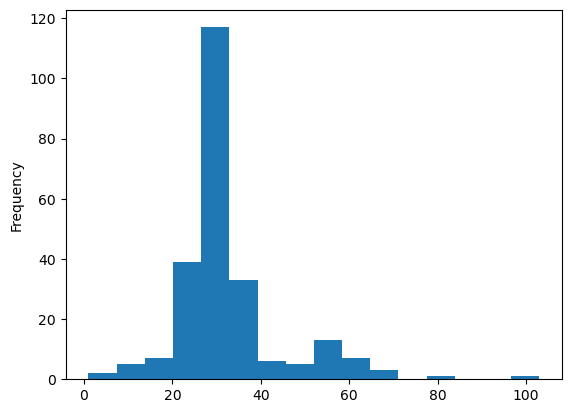

In [76]:
metar_station_counts.plot.hist(bins=16)

In [77]:
station_quantity = metars.reset_index(drop=True).groupby('station')['product_id'].count()
station_quantity

station
00U    16
1GM    41
1KM    47
1LM    17
28J    31
       ..
X07    26
X26    62
X60    28
XMR    57
ZPH    27
Name: product_id, Length: 239, dtype: int64

In [78]:
@dataclass
class DatasetUnit:
    stations: Set[str]
    quantity: int

    def __lt__(self, other):
         return (self.quantity, self.stations) < (other.quantity, self.stations)

In [79]:
stations_not_in_cluster = set(remaining_stations_metadata['name']).difference(set.union(*clusters))
print(stations_not_in_cluster)

{'1KM', 'FAT', 'BCR', 'NUC', 'VDF', 'IZA', 'CIC', 'SBP', 'CEC', 'F70', 'DWA', 'BLH', 'RDD', 'JAQ', 'HST', 'NSI', 'L52', 'LCQ', 'BIL', 'BIH', 'CTY', 'BKV', 'SBA', 'ECP', 'MVH', 'SAC', 'CCR', 'M75', '54A', 'O32', 'LWT', 'L35', 'AUN', 'AAF', 'SBD', 'S85', 'JAX', 'OLF', 'IMM', 'F45', 'VCV', 'GOO', 'DED', 'RBL', 'DLN', 'TSP', 'BLU', 'FUL', 'MCF', 'MKY', 'STS', 'GDV', 'FIN', 'BAN', 'TRM', 'BHK', 'X26', 'LEE', 'AGR', 'SUA', 'FPR', 'CTB', 'GNV', 'SDB', 'SEF', 'PRB', '42J', 'XMR', 'SFB', 'TCY', 'OCF', 'FHB', 'HVR', 'PVF', 'SIY', 'INF', 'TVL', 'C83', 'LHM', '2IS', 'BFL', 'CVH', 'PIE', 'FPY', 'PSP', 'MOD', 'NLC', 'HJO', 'DAG', 'APC', 'MLS', 'SNA', 'VRB', 'BTM', 'X07', 'K70', 'OXR', 'BZN', 'L08', '28J', '54J', 'TLH', 'WYS', 'PO1', 'LGB', 'EED', 'GGW', 'MSO', 'OVE', '6S0', 'LVM', 'ZPH', 'DLO', 'X60', 'E16', 'OBE', 'TMB', '1GM', 'MMH', 'O05', 'SMX', 'SMF', 'MHV', 'HMT', 'SGJ', '1LM', 'UKI', 'RVF', 'NSE', '00U', 'MHS', 'SDY', 'EKS', 'MTH', 'PWD', 'SRQ', 'PGD', 'HLN', 'BYS', 'VIS', 'PTV', 'MAI', 'TRK'

In [80]:
dataset_units: List[DatasetUnit] = []
for cluster in clusters:
    dataset_units += [DatasetUnit(cluster, sum([station_quantity.loc[station] for station in cluster]))]
dataset_units += [DatasetUnit(set([station]), station_quantity.loc[station]) for station in stations_not_in_cluster]
print(dataset_units)

[DatasetUnit(stations={'EDW', '9L2'}, quantity=61), DatasetUnit(stations={'RAL', 'POC', 'AJO', 'CNO', 'CCB', 'ONT'}, quantity=180), DatasetUnit(stations={'MYV', 'BAB'}, quantity=59), DatasetUnit(stations={'PMP', 'BCT'}, quantity=57), DatasetUnit(stations={'BOW', 'GIF'}, quantity=47), DatasetUnit(stations={'VNY', 'BUR', 'WHP'}, quantity=85), DatasetUnit(stations={'CEW', 'EGI'}, quantity=55), DatasetUnit(stations={'COF', 'MLB'}, quantity=113), DatasetUnit(stations={'CQT', 'SMO', 'HHR', 'TOA', 'LAX'}, quantity=145), DatasetUnit(stations={'HEG', 'VQQ', 'NRB', 'NIP', 'CRG'}, quantity=132), DatasetUnit(stations={'CRQ', 'NFG', 'OKB', 'NXF', 'L18'}, quantity=146), DatasetUnit(stations={'DAB', 'OMN'}, quantity=54), DatasetUnit(stations={'DTS', 'VPS', 'HRT'}, quantity=88), DatasetUnit(stations={'DVO', 'O69'}, quantity=58), DatasetUnit(stations={'NQX', 'EYW'}, quantity=27), DatasetUnit(stations={'OPF', 'FLL', 'MIA', 'HWO'}, quantity=126), DatasetUnit(stations={'RSW', 'FMY'}, quantity=59), Dataset

In [81]:
dataset_units_per_state: Dict[str, List[DatasetUnit]] = {}
for state in target_states:
    dataset_units_per_state[state] = list(filter(lambda x: station_metadata.loc[list(x.stations)[0], 'state'] == state, dataset_units))
print(dataset_units_per_state)

{'California': [DatasetUnit(stations={'EDW', '9L2'}, quantity=61), DatasetUnit(stations={'RAL', 'POC', 'AJO', 'CNO', 'CCB', 'ONT'}, quantity=180), DatasetUnit(stations={'MYV', 'BAB'}, quantity=59), DatasetUnit(stations={'VNY', 'BUR', 'WHP'}, quantity=85), DatasetUnit(stations={'CQT', 'SMO', 'HHR', 'TOA', 'LAX'}, quantity=145), DatasetUnit(stations={'CRQ', 'NFG', 'OKB', 'NXF', 'L18'}, quantity=146), DatasetUnit(stations={'DVO', 'O69'}, quantity=58), DatasetUnit(stations={'NUQ', 'PAO', 'SFO', 'HAF', 'HWD', 'OAK', 'SJC', 'SQL'}, quantity=232), DatasetUnit(stations={'NJK', 'IPL'}, quantity=60), DatasetUnit(stations={'VBG', 'LPC'}, quantity=48), DatasetUnit(stations={'MHR', 'MCC'}, quantity=62), DatasetUnit(stations={'MER', 'MCE'}, quantity=38), DatasetUnit(stations={'SAN', 'NKX', 'MYF', 'NRS', 'NZY'}, quantity=174), DatasetUnit(stations={'SNS', 'OAR'}, quantity=64), DatasetUnit(stations={'WJF', 'PMD'}, quantity=74), DatasetUnit(stations={'VCB', 'SUU'}, quantity=58), DatasetUnit(stations={'

Text(0.5, 0, 'Average number of METARS per satellite image')

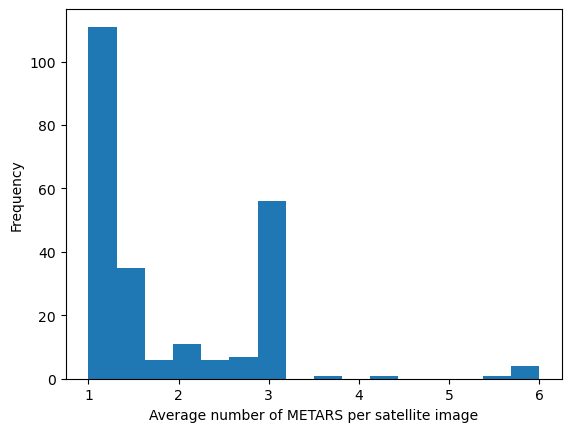

In [82]:
ax: plt.Axes = available_metars.groupby(['station', 'product_id'])['datetime'].count().groupby('station').mean().plot.hist(bins=16)
ax.set_xlabel('Average number of METARS per satellite image')

Text(0.5, 0, 'quantity of METARs')

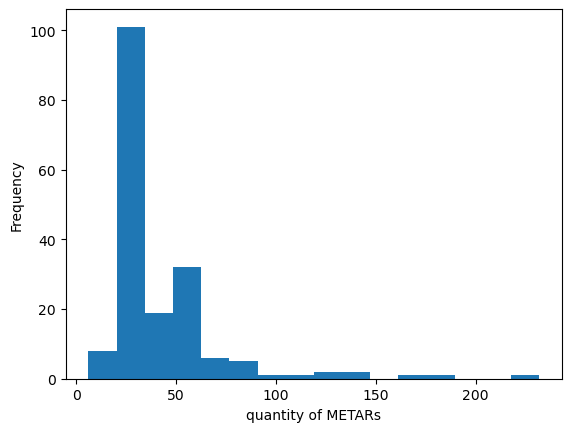

In [83]:
ax: plt.Axes = pd.DataFrame(dataset_units).plot.hist(bins=16, legend=False)
ax.set_xlabel('quantity of METARs')

In [84]:
total_quantity = sum([entry.quantity for entry in dataset_units])
print(f'In total, {total_quantity} units of data are to be distributed for the dataset')

quantity_per_state: Dict[str, int] = {}
for state in target_states:
    quantity_per_state[state] = sum([entry.quantity for entry in dataset_units_per_state[state]])
    print(f'{state} has {quantity_per_state[state]} units of data')

In total, 7783 units of data are to be distributed for the dataset
California has 4220 units of data
Montana has 988 units of data
Florida has 2575 units of data


In [85]:
@dataclass
class DatasetSplit:
    training: float
    validation: float
    test: float

    def __init__(self, training: float, validation: float, test: float) -> None:
        if not math.isclose(training + validation + test, 1.0):
            raise ValueError('DatasetSplit must sum to 1.0 (100 %)')
        self.training = training
        self.validation = validation
        self.test = test
    
    def getAbsoluteNumbers(self, total_quantity:int) -> Tuple[int, int, int]:
        test_abs        = int(math.ceil(total_quantity * self.test))
        validation_abs  = int(math.ceil(total_quantity * self.validation))
        training_abs    = total_quantity - test_abs - validation_abs
        return (training_abs, validation_abs, test_abs)

In [86]:
dataset_split = DatasetSplit(0.80, 0.10, 0.10)
num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
print(f'DatasetSplit target:'
      f'\nTraining:\t{num_training}\t[{dataset_split.training * 100.0:.2f} %]'
      f'\nValidation:\t{num_validation}\t[{dataset_split.validation * 100.0:.2f} %]'
      f'\nTest:\t\t{num_test}\t[{dataset_split.test * 100.0:.2f} %]')

DatasetSplit target:
Training:	6225	[80.00 %]
Validation:	779	[10.00 %]
Test:		779	[10.00 %]


In [87]:
for state in target_states:
    dataset_units_per_state[state].sort(reverse=True)

In [88]:
@dataclass
class Dataset:
    data: List[DatasetUnit]
    current_size: int
    target_size: int

    def add(self, unit:DatasetUnit):
        self.data += [unit]
        self.current_size += unit.quantity

    def get_missing_quantity(self) -> int:
        return self.target_size - self.current_size
    
    def get_stations(self) -> Set[str]:
        return set.union(*[x.stations for x in self.data])
    
    @staticmethod
    def merge(a, b):
        return Dataset(a.data + b.data, a.current_size + b.current_size, a.target_size + b.target_size)

In [89]:
def greedy_partition(split:DatasetSplit, total_quantity:int, data:List[DatasetUnit]):
    num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
    training    = Dataset([], 0, num_training)
    validation  = Dataset([], 0, num_validation)
    test        = Dataset([], 0, num_test)
    for unit in data:
        # Get the dataset that is missing the most data
        next_dataset = max([
            (training.get_missing_quantity(),      training),
            (validation.get_missing_quantity(),  validation),
            (test.get_missing_quantity(),              test)
        ], key=lambda x: x[0])[1]
        next_dataset.add(unit)
    return (training, validation, test)

In [90]:
training    : Optional[Dataset] = None
validation  : Optional[Dataset] = None
test        : Optional[Dataset] = None
for state in target_states:
      training_subset, validation_subset, test_subset = \
            greedy_partition(dataset_split, quantity_per_state[state], dataset_units_per_state[state])
      if training is None:
            training = training_subset
      else:
            training = Dataset.merge(training, training_subset)
      if validation is None:
            validation = validation_subset
      else:
            validation = Dataset.merge(validation, validation_subset)
      if test is None:
            test = test_subset
      else:
            test = Dataset.merge(test, test_subset)
print(f'DatasetSplit:'
      f'\nTraining:\t{training.current_size}\t[{float(training.current_size) / float(total_quantity) * 100.0:.2f} %]'
      f'\nValidation:\t{validation.current_size}\t[{float(validation.current_size) / float(total_quantity) * 100.0:.2f} %]'
      f'\nTest:\t\t{test.current_size}\t[{float(test.current_size) / float(total_quantity) * 100.0:.2f} %]')

DatasetSplit:
Training:	6224	[79.97 %]
Validation:	783	[10.06 %]
Test:		776	[9.97 %]


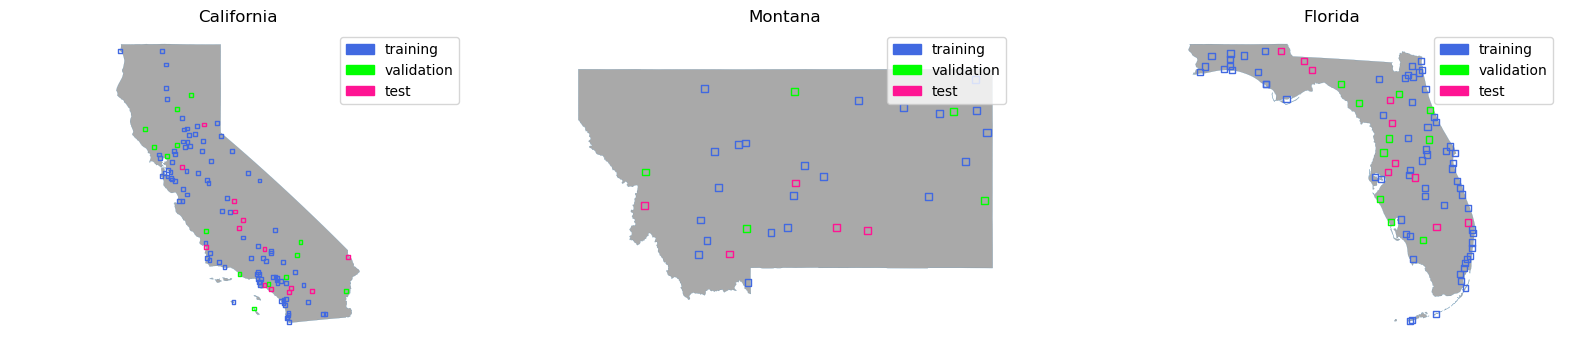

In [91]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    color_training = 'royalblue'
    color_validation = 'lime'
    color_test = 'deeppink'

    patch_training = mpatches.Patch(color=color_training, label='training')
    patch_validation = mpatches.Patch(color=color_validation, label='validation')
    patch_test = mpatches.Patch(color=color_test, label='test')

    selected_stations_metadata = remaining_stations_metadata.loc[list(training.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_training, legend=True
    )

    selected_stations_metadata = remaining_stations_metadata.loc[list(validation.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_validation, legend=True
    )

    selected_stations_metadata = remaining_stations_metadata.loc[list(test.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_test, legend=True
    )

    ax.legend(handles=[patch_training, patch_validation, patch_test])

In [92]:
os.makedirs(dataset_dir, exist_ok=True)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [93]:
print(training.get_stations())

{'1KM', 'OAR', 'POC', 'EYW', 'FAT', 'SJC', 'BCR', 'IZA', 'SBP', 'PAO', 'NQX', 'NIP', 'MHR', 'CEC', 'PMP', 'DTS', 'LPC', 'GTF', 'MIA', 'RDD', 'JAQ', 'HST', 'NSI', 'LCQ', 'PMD', 'BIH', 'VPS', 'BOW', 'SBA', 'NPA', 'ECP', 'MVH', 'SAC', 'MER', 'CCR', 'M75', 'CRQ', 'IPL', 'LWT', 'L35', 'MYV', 'AUN', 'AAF', 'MCC', 'SUU', 'NRS', 'S85', 'PBI', 'OLF', 'JAX', 'HWO', 'GFA', 'WHP', 'VCV', 'LNA', 'GOO', 'DED', 'RBL', 'DLN', 'TSP', 'CQT', 'OKB', 'CEW', 'MCF', 'MKY', 'WJF', 'GDV', 'ORL', 'SQL', 'VCB', 'BAN', 'AJO', 'HEG', 'TTS', 'X26', 'TOA', 'LEE', 'AGR', 'SUA', '9L2', 'FPR', 'CTB', 'SDB', 'OMN', 'SEF', 'SMO', 'NJK', 'XMR', 'GIF', 'BUR', 'TCY', 'FLL', 'VBG', 'FHB', 'PVF', 'SIY', 'HRT', 'HAF', 'TVL', 'HWD', 'MCO', 'LHM', 'CRG', 'DVO', 'BFL', 'CVH', 'PIE', 'FMY', 'OPF', 'PSP', 'MOD', 'NLC', 'O69', 'HJO', 'NXF', 'L18', 'MLS', 'SNS', 'VRB', 'BTM', 'TIX', 'K70', 'PAM', 'L08', '28J', '54J', 'COF', 'WYS', 'GGW', 'RAL', 'OVE', '6S0', 'BCT', 'LVM', 'X60', 'E16', 'OBE', 'TMB', 'LAX', 'PNS', '1GM', 'MMH', 'NFG'

In [94]:
all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
all_band_resolutions_meters = [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20]
bands_metadata = pd.DataFrame([all_bands, all_band_resolutions_meters]).T
bands_metadata.columns = ['band', 'resolution [m]']
bands_metadata.set_index('band', inplace=True)
bands_metadata

,resolution [m]
band,
B1,60
B2,10
B3,10
B4,10
B5,20
B6,20
B7,20
B8,10
B8A,20


In [95]:
bands_subset = ['B2', 'B3', 'B4']
assert pd.Series(bands_subset).isin(bands_metadata.index).all(), 'Some bands are invalid!'

In [96]:
def get_features_path(station:str, product_id:str, band:str):
    features_dir = state_dirs.loc[station_metadata.loc[station, 'state'], 'features']
    return os.path.join(features_dir, product_id, band, f'{station}.jp2')

def get_dataset_local_dir(station:str, product_id:str):
    return os.path.join(station, product_id)

def get_dataset_path(target_dir:str, station:str, product_id:str, band:str):
    return os.path.join(target_dir, get_dataset_local_dir(station, product_id), f'{band}.jp2')

def map_files_to_dataset_paths(dataset:Dataset, target_dir:str) -> List[Tuple[str, str]]:
    data_subset = metars[(metars['station'].isin(dataset.get_stations()))\
                                   & (metars['max cloud cover'].isin(cloud_covers_order))]
    result = data_subset.apply(
        lambda x: [(get_features_path(x.station, x.product_id, band),
                    get_dataset_path(target_dir, x.station, x.product_id, band)) for band in bands_subset], axis=1)
    return [x for sublist in result for x in sublist]

In [97]:
dataset_file_mappings = [mapping for sublist in [
    map_files_to_dataset_paths(training, training_dir),
    map_files_to_dataset_paths(validation, validation_dir),
    map_files_to_dataset_paths(test, test_dir)
] for mapping in sublist]

In [98]:
for path_from, path_to in tqdm(dataset_file_mappings):
    os.makedirs(os.path.dirname(path_to), exist_ok=True)
    if not os.path.exists(path_to):
        shutil.copyfile(path_from, path_to)

100%|██████████| 23349/23349 [00:11<00:00, 2037.98it/s]


In [99]:
def create_dataset_labels(dataset:Dataset):
    labels = metars.reset_index(drop=True)
    labels = labels[labels['station'].isin(dataset.get_stations())\
                              & (labels['max cloud cover'].isin(cloud_covers_order))].copy()
    labels['timedelta [minutes]'] = labels['timedelta'].map(lambda x: x.total_seconds() / 60.0)
    labels = labels[['max cloud cover', 'temperature [C]', 'timedelta [minutes]', 'station', 'product_id']]
    return labels.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))

In [100]:
training_labels = create_dataset_labels(training)
validation_labels = create_dataset_labels(validation)
test_labels = create_dataset_labels(test)

<Axes: title={'center': 'Test'}, ylabel='Frequency'>

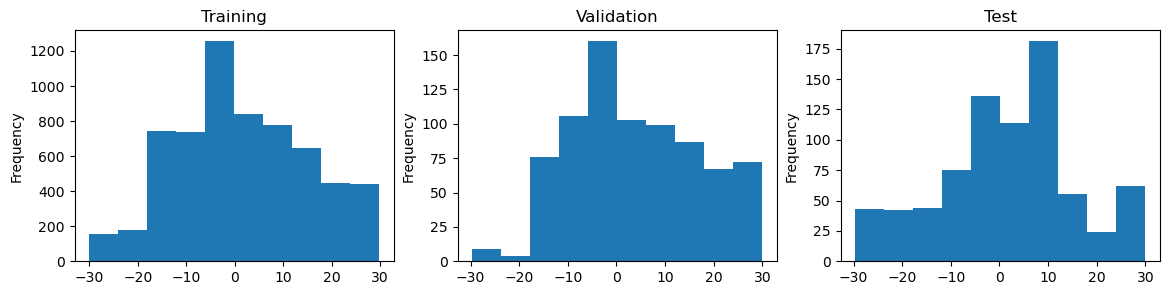

In [101]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[0], title='Training')
validation_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[1], title='Validation')
test_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[2], title='Test')

In [102]:
def print_time_dist(data:pd.DataFrame, name:str):
    series = data['timedelta [minutes]']
    print(f'{name}\tmean offset: {series.mean():.1f} minutes,\tvariance: {series.var():.1f}')

print_time_dist(training_labels, 'Training')
print_time_dist(validation_labels, 'Validation')
print_time_dist(test_labels, 'Test\t')

Training	mean offset: 1.9 minutes,	variance: 182.1
Validation	mean offset: 3.9 minutes,	variance: 169.9
Test		mean offset: 1.6 minutes,	variance: 192.3


In [103]:
training_labels.shape[0]

6224

In [104]:
training_label_counts = pd.Series(dict(Counter(training_labels['max cloud cover'])))
validation_label_counts = pd.Series(dict(Counter(validation_labels['max cloud cover'])))
test_label_counts = pd.Series(dict(Counter(test_labels['max cloud cover'])))

<Axes: title={'center': 'Test'}>

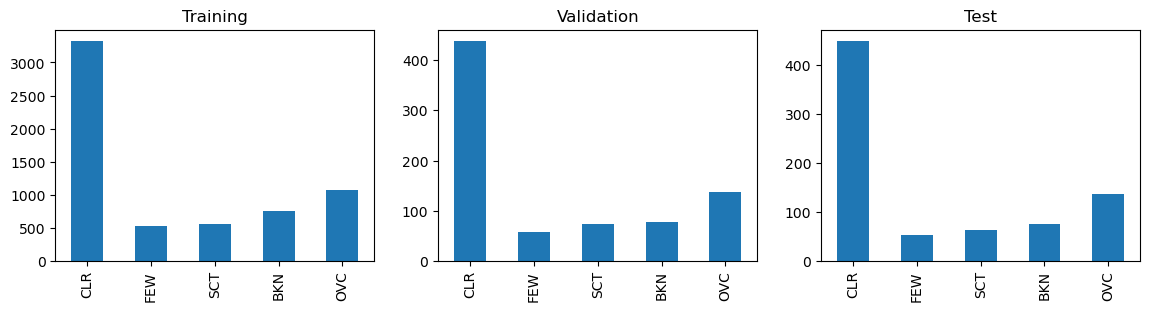

In [105]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[0], title='Training')
validation_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[1], title='Validation')
test_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[2], title='Test')

In [106]:
training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index=False)
validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index=False)
test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index=False)

In [107]:
def get_label_weights(label_counts:pd.DataFrame):
    label_weights = pd.DataFrame(label_counts.sum() / label_counts, columns=['weight'])
    # label_weights = pd.DataFrame(1.0 - np.sqrt(label_counts / label_counts.sum()), columns=['weight'])
    label_weights.index.set_names('label', inplace=True)
    return label_weights.loc[cloud_covers_order]

In [108]:
training_weights = get_label_weights(training_label_counts)
training_weights

,weight
label,
CLR,1.870192
FEW,11.810247
SCT,11.316364
BKN,8.254642
OVC,5.844131


In [109]:
training_label_counts.loc[cloud_covers_order] * training_weights.loc[cloud_covers_order]['weight']

label
CLR    6224.0
FEW    6224.0
SCT    6224.0
BKN    6224.0
OVC    6224.0
dtype: float64

In [110]:
training_weights.to_csv(os.path.join(dataset_dir, 'training_weights.csv'))

In [108]:
bands_metadata.to_csv(os.path.join(dataset_dir, 'bands_metadata.csv'), index=True)